In [117]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt

print("Hello world.")

Hello world.


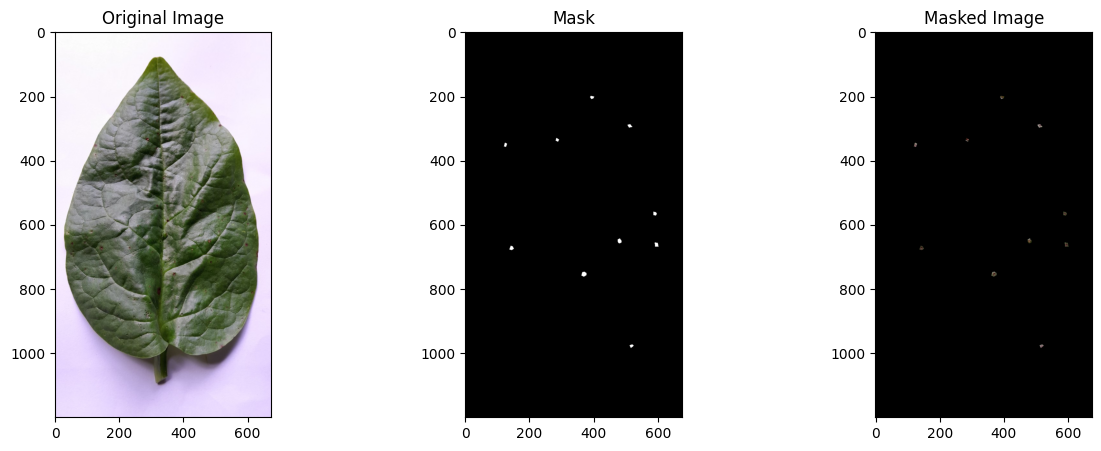

In [118]:


image_path = r"/kaggle/input/malabar-dataset/Malabar_Dataset/Bacterial-Spot(752)/Bacterial-Spot (1).jpg"
image = cv2.imread(image_path)

json_path = r"/kaggle/input/temp-dataset/annotated_json_files/Bacterial-Spot(752)/affected_region/Bacterial-Spot (1).json"
with open(json_path, 'r') as file:
    data = json.load(file)

# Create a blank mask with the same dimensions as the input image
mask = np.zeros(image.shape[:2], dtype=np.uint8)

if 'shapes' in data:
    for annotation in data['shapes']:
        points = np.array(annotation['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], color=255)
elif 'annotations' in data:
    for annotation in data['annotations']:
        points = np.array(annotation['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], color=255)
else:
    print("No valid keys ('shapes' or 'annotations') found in JSON.")

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Display the original image, mask, and masked image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Masked Image")
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.show()

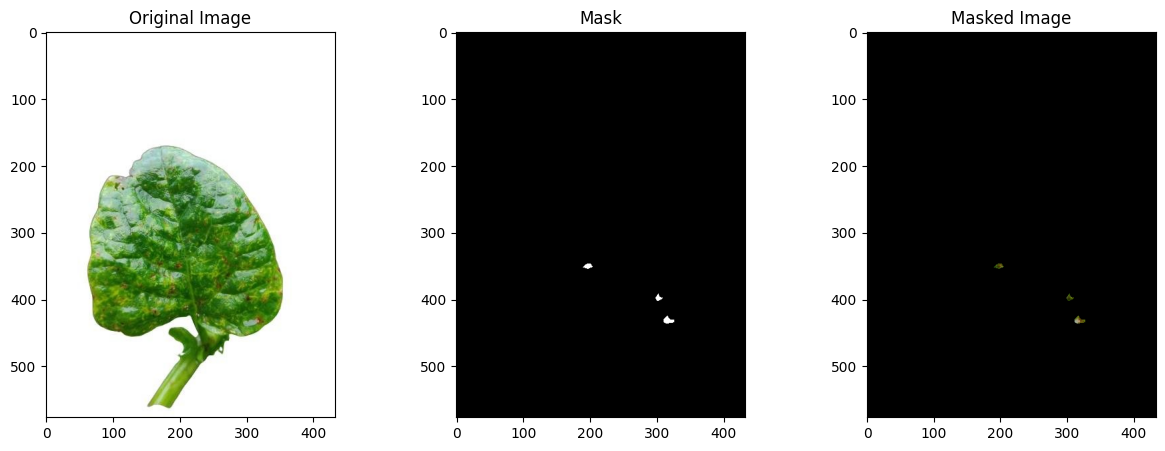

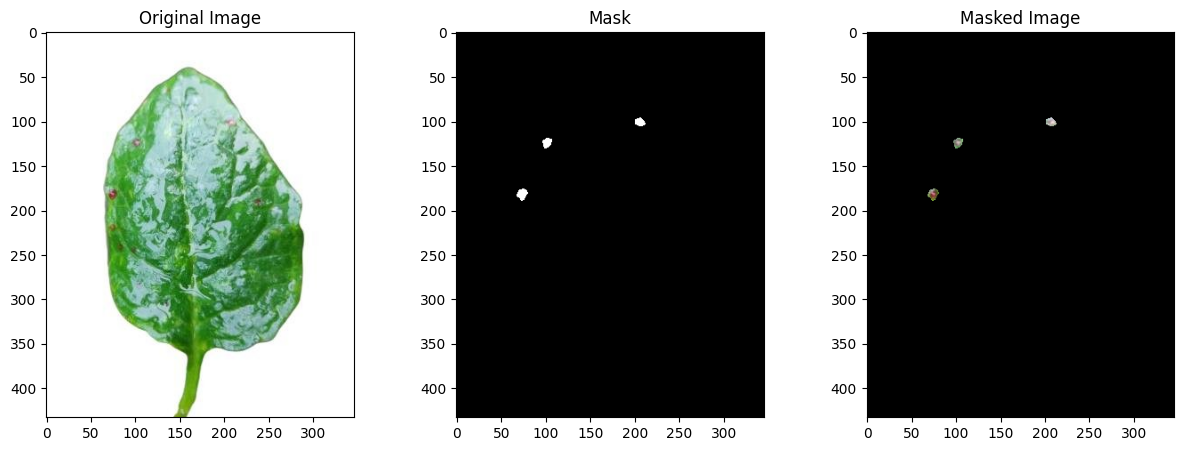

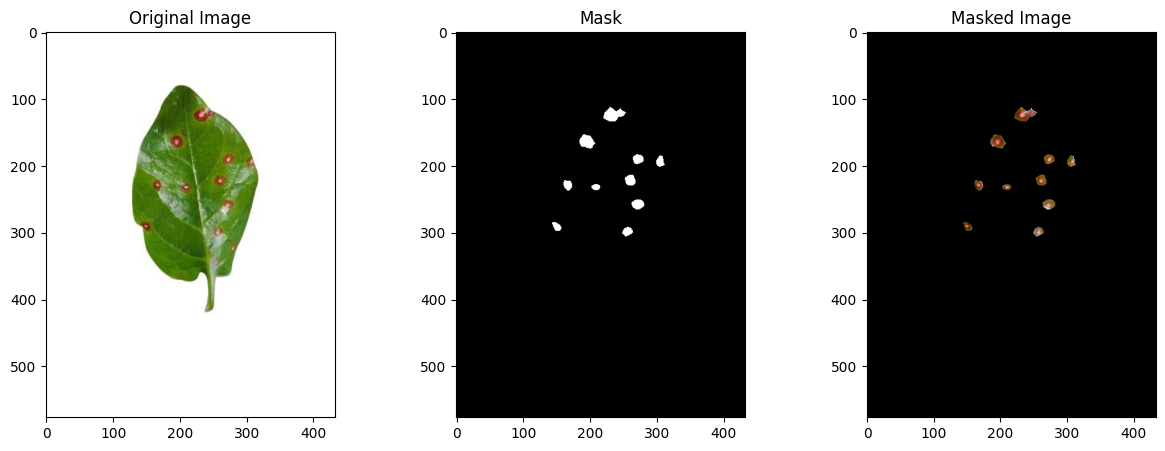

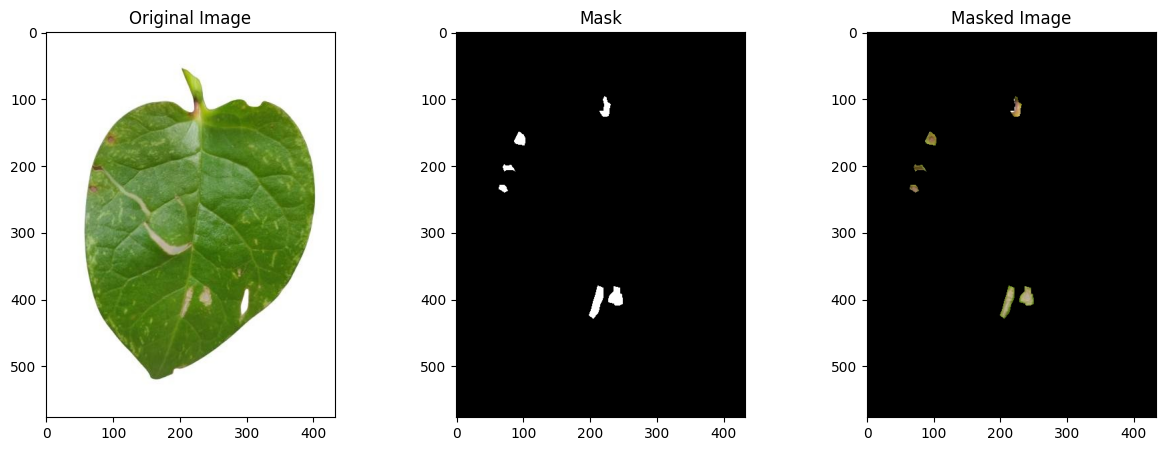

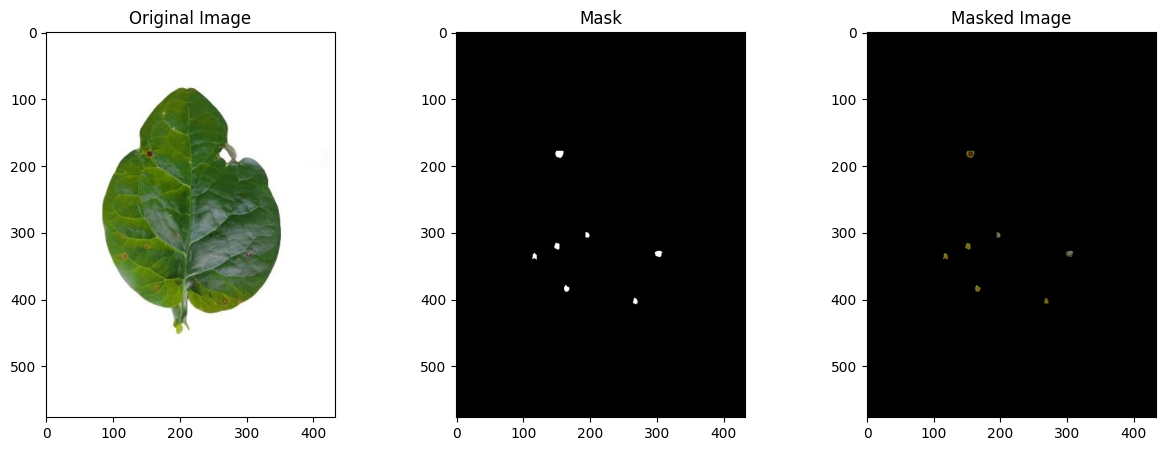

In [119]:
i = 0 
image_path = "/kaggle/input/malabar-dataset/Malabar_Dataset/Bacterial-Spot(752)"
json_path = "/kaggle/input/temp-dataset/annotated_json_files/Bacterial-Spot(752)/affected_region"
for i in range(45, 50):
    image_name = "Bacterial-Spot ("+str(i+1)+").jpg"
    json_file_name = "Bacterial-Spot ("+str(i+1)+").json"
    #print(image_name)
    #print(json_file_name)
    image = cv2.imread(image_path+'/'+image_name)
    json_file = json_path + '/' + json_file_name
    #print(json_file)

    with open(json_file, 'r') as file:
        data = json.load(file)

    # Create a blank mask with the same dimensions as the input image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    if 'shapes' in data:
        for annotation in data['shapes']:
            points = np.array(annotation['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=255)
    elif 'annotations' in data:
        for annotation in data['annotations']:
            points = np.array(annotation['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=255)
    else:
        print("No valid keys ('shapes' or 'annotations') found in JSON.")

    masked_image = cv2.bitwise_and(image, image, mask=mask)


    # Display the original image, mask, and masked image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Masked Image")
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

    plt.show()




In [120]:
def create_mask(json_file, image_shape):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    for shape in data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    
    return mask


train_images, valid_images, test_images = [], [], []
train_masks, valid_masks, test_masks = [], [], []

for i in range(0, 50):

    json_file_name = "Bacterial-Spot ("+str(i+1)+").json"
    json_file = json_path + '/' + json_file_name
    
    image_name = "Bacterial-Spot ("+str(i+1)+").jpg"
    image = cv2.imread(image_path+'/'+image_name)
    if image is None:
        continue
    
    mask = create_mask(json_file, image.shape)
    
    # Save mask
    #mask_path = os.path.join(mask_dir, f'mask_{i+1}.png')
    #cv2.imwrite(mask_path, mask)
    
    if i < 40:
        train_images.append(image)
        train_masks.append(mask)
    elif i < 45:
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)


print("Hello world.")

Hello world.


In [121]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet_model = build_unet()
unet_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_176[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 128, 128,  │          0 │ conv2d_177[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_32… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_178[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 64, 64,    │          0 │ conv2d_179[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_33… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_180[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_32    │ (None, 128, 128,  │          0 │ conv2d_181[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 128, 128,  │          0 │ up_sampling2d_32… │
│ (Concatenate)       │ 384)              │            │ conv2d_179[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 128, 128,  │    442,496 │ concatenate_32[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_183 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_182[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_33    │ (None, 256, 256,  │          0 │ conv2d_183[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 256, 256,  │          0 │ up_sampling2d_33… │
│ (Concatenate)       │ 192)              │            │ conv2d_177[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_184 (Conv2D) │ (None, 256, 256,  │    110,656 │ concatenate_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_185 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_184[0][0]

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array

# Prepare datasets
X_train, y_train = preprocess_data(train_images, train_masks)
X_valid, y_valid = preprocess_data(valid_images, valid_masks)
X_test, y_test = preprocess_data(test_images, test_masks)

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

# Train the model
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9620 - loss: 0.4639
Epoch 1: val_loss improved from inf to 0.16354, saving model to unet_best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 520ms/step - accuracy: 0.9653 - loss: 0.4353 - val_accuracy: 0.9937 - val_loss: 0.1635
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9969 - loss: 0.0468
Epoch 2: val_loss improved from 0.16354 to 0.03681, saving model to unet_best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.9969 - loss: 0.0458 - val_accuracy: 0.9937 - val_loss: 0.0368
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9971 - loss: 0.0324
Epoch 3: val_loss did not improve from 0.03681
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.9970 - loss: 0.0325 - val_accuracy: 0.9937 - val_loss: 0.0574
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9968 - loss: 0.0245
Epoch 4: val_loss improved from 0.03681 to 0.03178, saving model to unet_best_model.keras
5/5 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


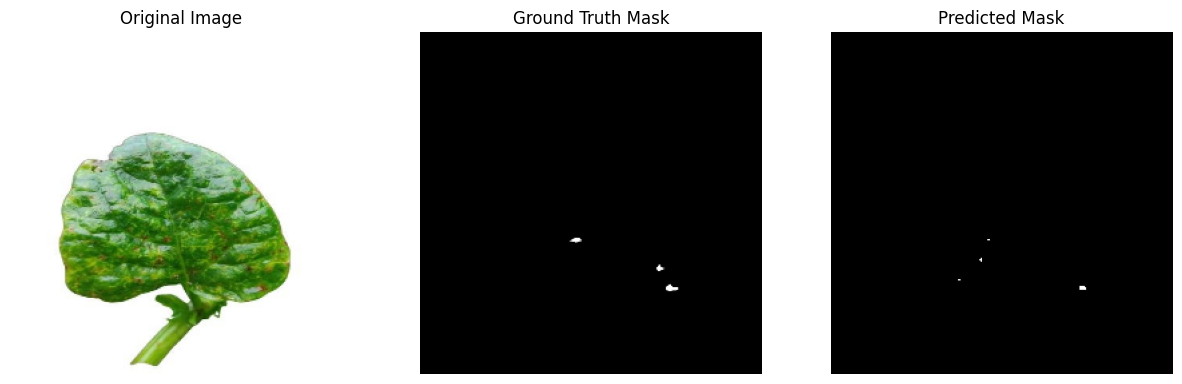

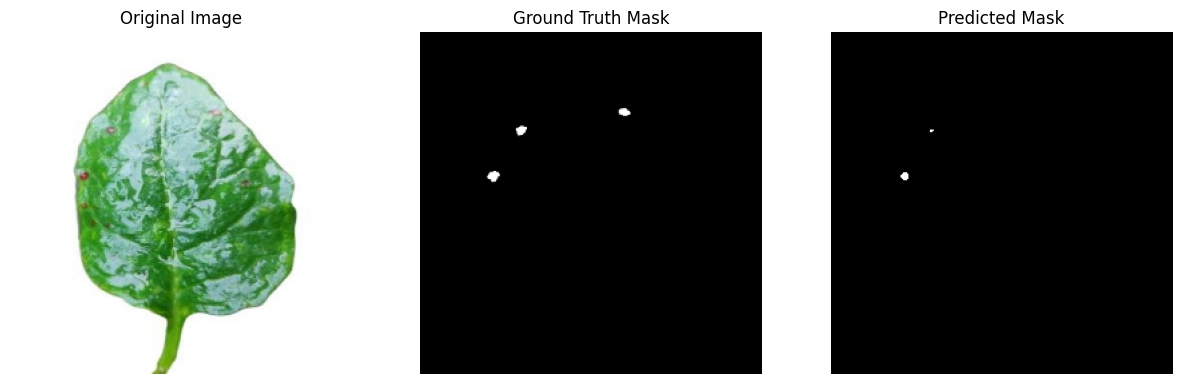

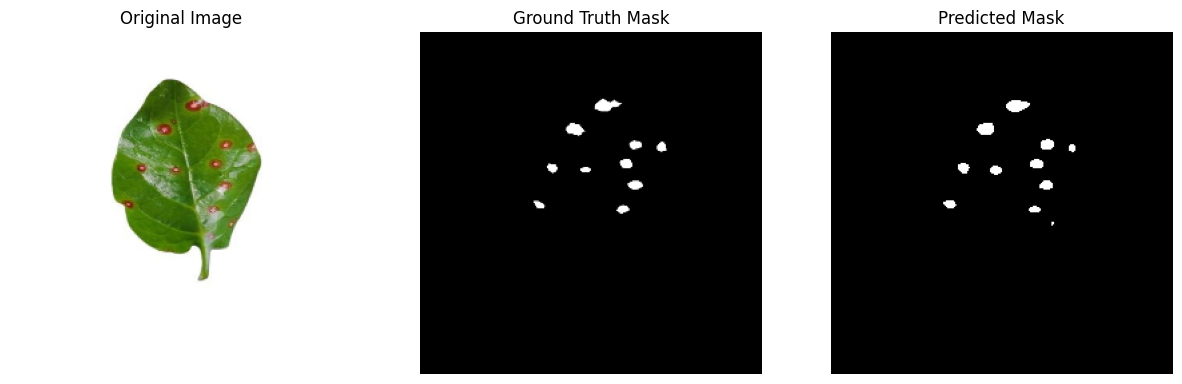

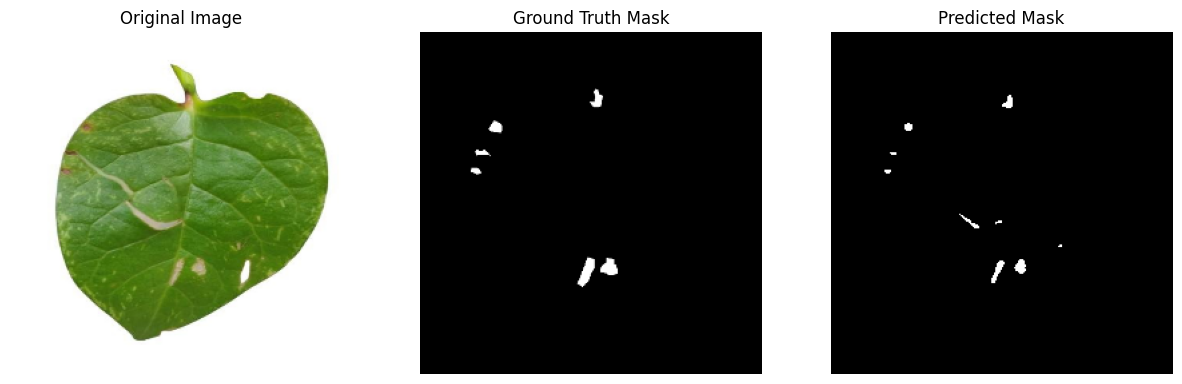

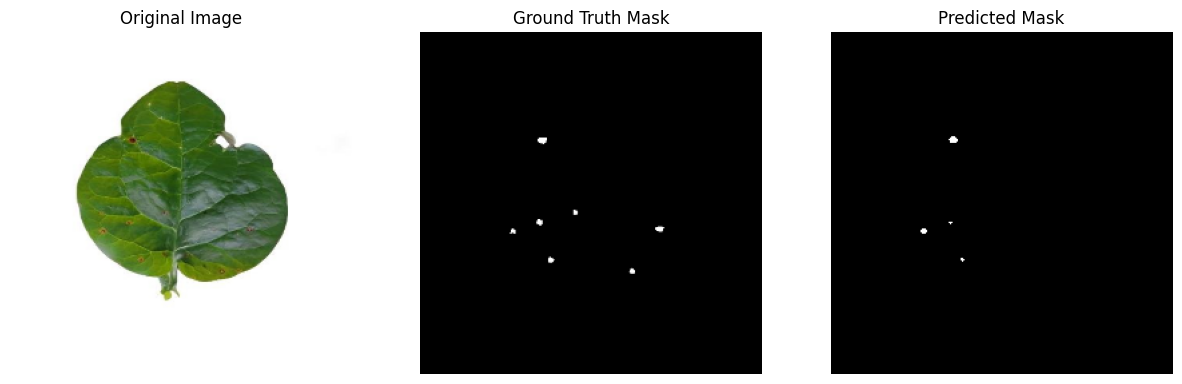

In [123]:


import matplotlib.pyplot as plt
import cv2
import numpy as np

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Make predictions on the test set
predictions = unet_model.predict(X_test)

# Create masks from the predictions
predicted_masks = create_mask(predictions)

# Function to visualize the results
def visualize_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        # Original image
        img = images[i]
        # Ground truth mask
        true_mask = masks[i]
        # Predicted mask
        predicted_mask = predictions[i]
        
        # Plotting
        plt.figure(figsize=(15, 5))
        
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Visualizing the results
visualize_results(X_test, y_test, predicted_masks, num_images=5)

# Optionally, you can save some of the predicted masks for further analysis
def save_predicted_masks(predictions, output_dir="predicted_masks"):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for i, pred in enumerate(predictions):
        mask_path = os.path.join(output_dir, f"pred_mask_{i}.png")
        cv2.imwrite(mask_path, (pred.squeeze() * 255).astype(np.uint8))  # Save as binary image

# Save the predicted masks
save_predicted_masks(predicted_masks)







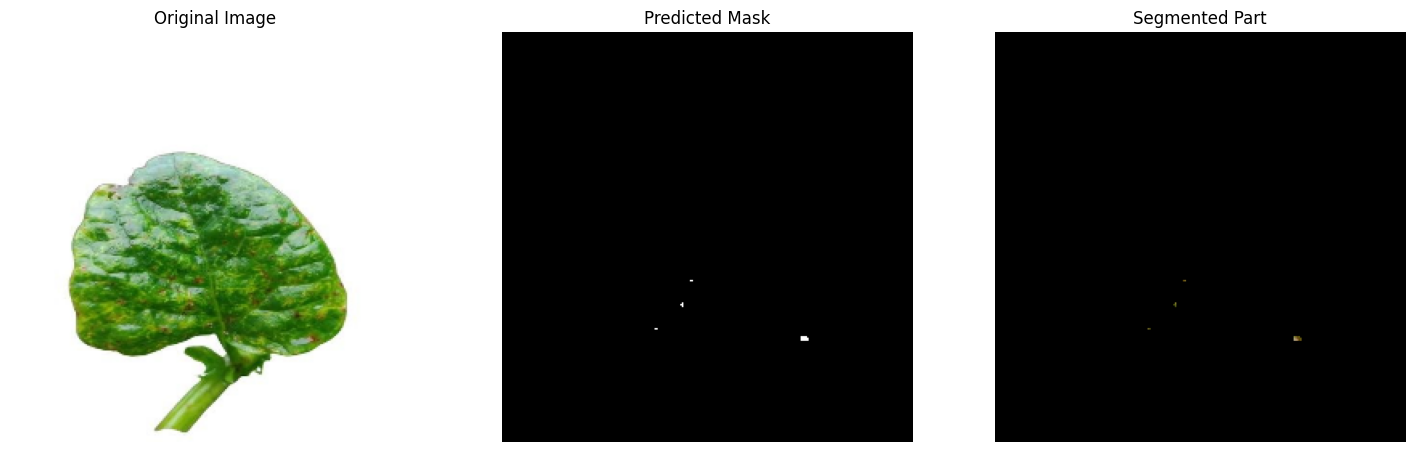

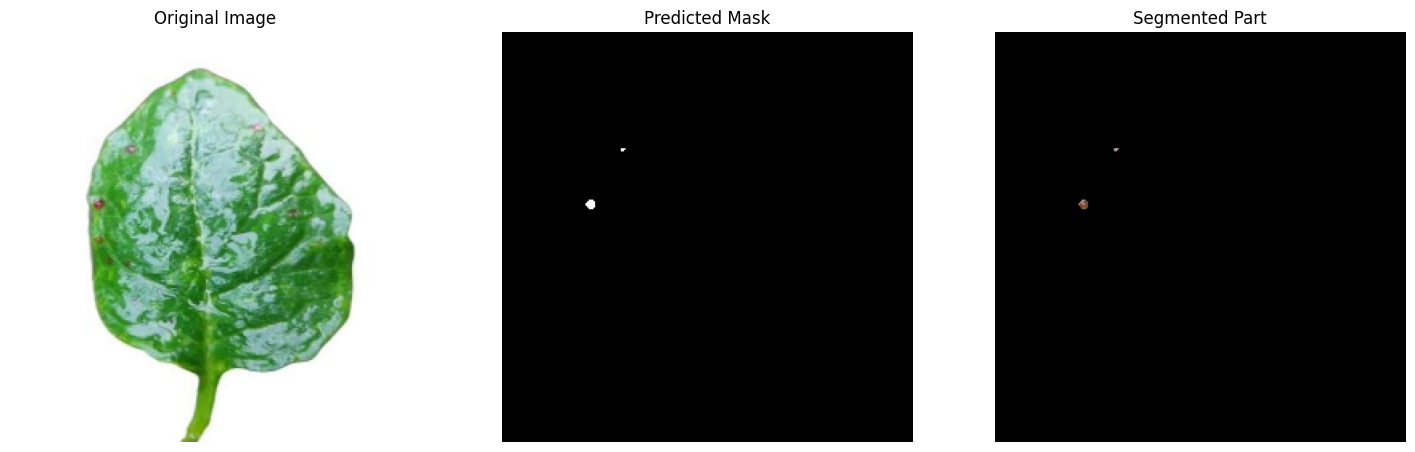

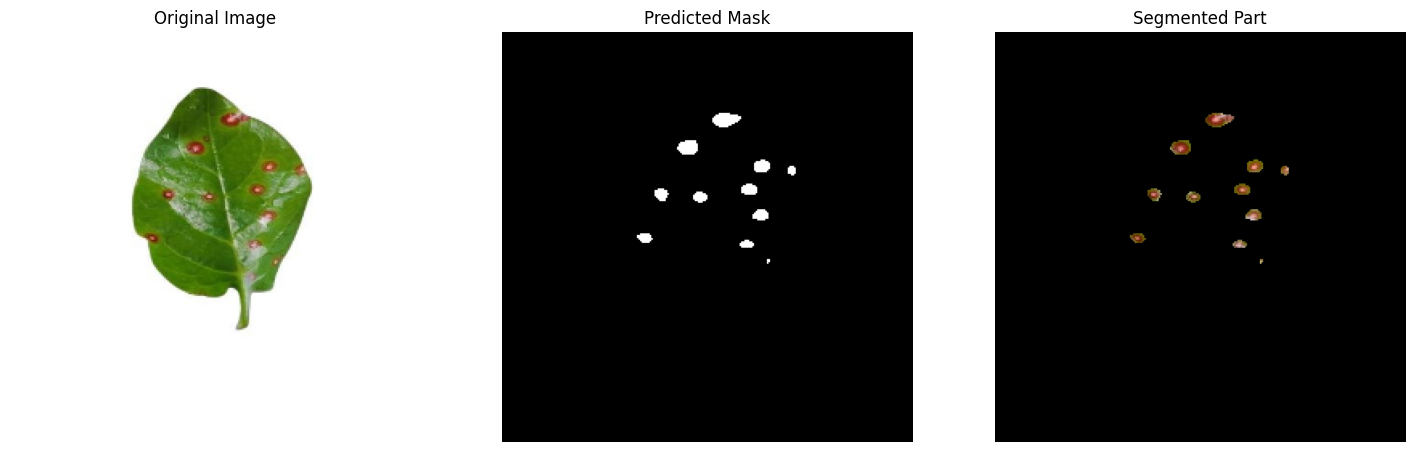

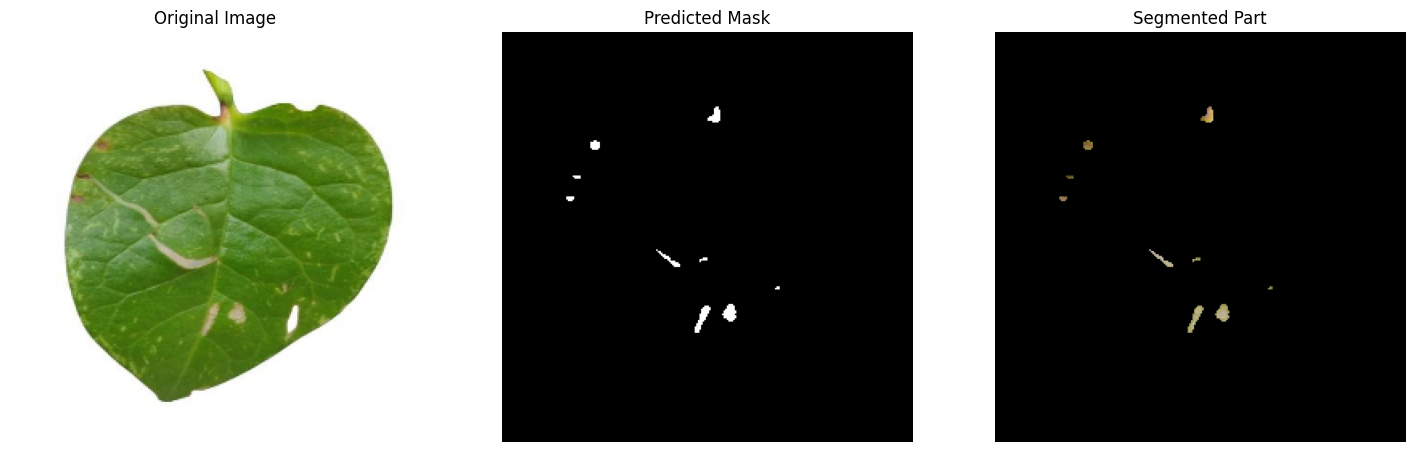

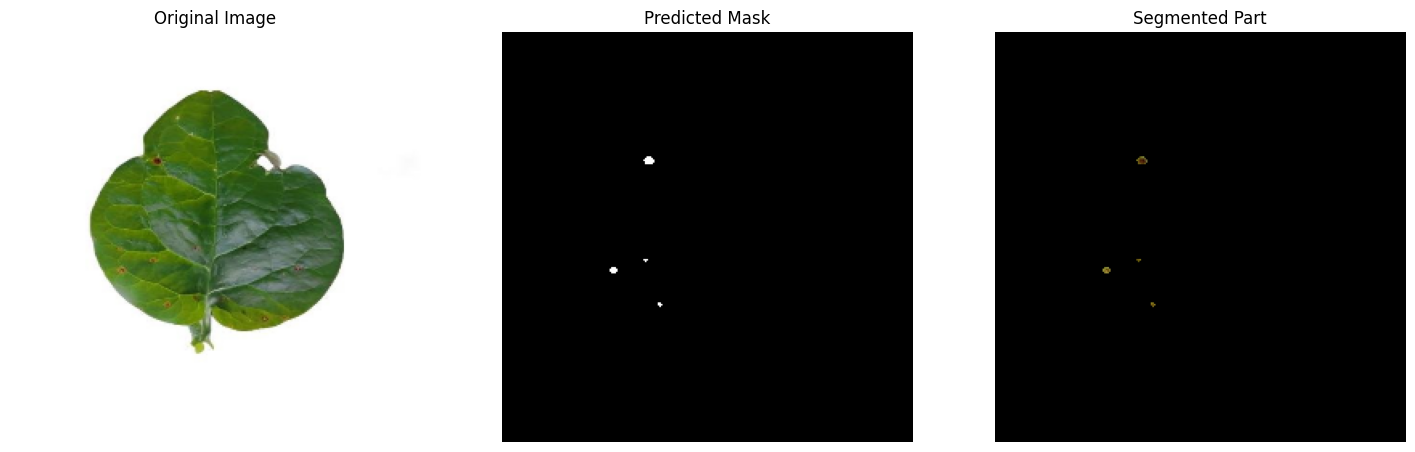

In [124]:
# Function to create segmented images using predicted masks
def get_segmented_image(image, mask):
    # Ensure mask has same dimensions as image
    if len(mask.shape) == 2:
        mask = mask[..., np.newaxis]  # add channel dimension if needed
    
    # Multiply image by mask
    segmented = cv2.bitwise_and(image, image, mask=mask.squeeze().astype(np.uint8))
    return segmented

# Function to visualize original, mask, and segmented image
def visualize_results_with_segmented(images, masks, num_images=5):
    for i in range(num_images):
        img = images[i]
        predicted_mask = masks[i]

        # Get segmented image
        segmented_img = get_segmented_image(img, predicted_mask)

        # Plotting
        plt.figure(figsize=(18, 6))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        # Segmented image
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.title('Segmented Part')
        plt.axis('off')

        plt.show()

# Visualize results
visualize_results_with_segmented(X_test, predicted_masks, num_images=5)


# Optionally save segmented images
def save_segmented_images(images, masks, output_dir="segmented_images"):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, (img, mask) in enumerate(zip(images, masks)):
        segmented_img = get_segmented_image(img, mask)
        save_path = os.path.join(output_dir, f"segmented_{i}.png")
        cv2.imwrite(save_path, cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))

# Save segmented images
save_segmented_images(X_test, predicted_masks)
